In [1]:
!pip install deap

In [2]:
from deap import base
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
import random
import numpy
import elitism

from tensorflow.keras.datasets import mnist
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils.testing import ignore_warnings
from math import floor

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
class MlpHyperparametersTest:

    NUM_FOLDS = 5

    def __init__(self, randomSeed):

        self.randomSeed = randomSeed
        self.initDataset()
        self.kfold = model_selection.KFold(n_splits=self.NUM_FOLDS, random_state=self.randomSeed)

    def initDataset(self):
        
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        self.X = numpy.vstack((x_train,x_test))
        self.X = self.X / 255.0
        self.X = self.X.reshape(self.X.shape[0], -1)
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        self.y = numpy.vstack((y_train,y_test))        
        self.y = self.y.flatten()

    def convertParams(self, params):

        if round(params[1]) <= 0:
            hiddenLayerSizes = round(params[0]),
        elif round(params[2]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]))
        elif round(params[3]) <= 0:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]))
        else:
            hiddenLayerSizes = (round(params[0]), round(params[1]), round(params[2]), round(params[3]))

        learning_rate_init = numpy.power(10, params[4])
        solver = ['sgd', 'adam'][floor(params[5])]        
        return hiddenLayerSizes, learning_rate_init, solver
        
    @ignore_warnings(category=ConvergenceWarning)
    def getAccuracy(self, params):
        hiddenLayerSizes, learning_rate_init, solver = self.convertParams(params)
        self.classifier = MLPClassifier(random_state=self.randomSeed,
                                        hidden_layer_sizes=hiddenLayerSizes,
                                        activation='relu',
                                        solver=solver,
                                        learning_rate_init=learning_rate_init,
                                        max_iter = 10)

        cv_results = model_selection.cross_val_score(self.classifier,
                                                     self.X,
                                                     self.y,
                                                     cv=self.kfold,
                                                     scoring='accuracy')

        return cv_results.mean()

    def predecir(self, params, X_train):
        hiddenLayerSizes, learning_rate_init, solver = self.convertParams(params)
        self.classifier = MLPClassifier(random_state=self.randomSeed,
                                        hidden_layer_sizes=hiddenLayerSizes,
                                        activation='relu',
                                        solver=solver,
                                        batch_size=32,
                                        learning_rate_init=learning_rate_init,
                                        max_iter = 10)

        self.classifier.fit(self.X, self.y)
        predicted = self.classifier.predict(X_train)
        return predicted      


    def formatParams(self, params):
        hiddenLayerSizes, learning_rate_init, solver = self.convertParams(params)
        
        return "'hidden_layer_sizes'={}\n " \
               "'solver'='{}'\n " \
               "'learning_rate_init'='{}'\n " \
            .format(hiddenLayerSizes, solver, learning_rate_init)

In [0]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

BOUNDS_LOW =  [ 5,  -5, -10, -20, -3, 0]
BOUNDS_HIGH = [15,  15,  15,  15, -1, 1.999]

NUM_OF_PARAMS = len(BOUNDS_HIGH)

POPULATION_SIZE = 7
P_CROSSOVER = 0.8
P_MUTATION = 0.2 
MAX_GENERATIONS = 3
HALL_OF_FAME_SIZE = 2
CROWDING_FACTOR = 10.0 

In [5]:
def classificationAccuracy(individual):
    return test.getAccuracy(individual),

test = MlpHyperparametersTest(RANDOM_SEED)
toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

for i in range(NUM_OF_PARAMS):
    toolbox.register("attribute_" + str(i), random.uniform, BOUNDS_LOW[i], BOUNDS_HIGH[i])

attributes = ()
for i in range(NUM_OF_PARAMS):
    attributes = attributes + (toolbox.__getattribute__("attribute_" + str(i)),)

toolbox.register("individualCreator", tools.initCycle, creator.Individual, attributes, n=1)
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)
toolbox.register("evaluate", classificationAccuracy)
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUNDS_LOW, up=BOUNDS_HIGH, eta=CROWDING_FACTOR, indpb=1.0/NUM_OF_PARAMS)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [6]:
population = toolbox.populationCreator(n=POPULATION_SIZE)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", numpy.max)
stats.register("avg", numpy.mean)
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)
population, logbook = elitism.eaSimpleWithElitism(population,
                                                  toolbox,
                                                  cxpb=P_CROSSOVER,
                                                  mutpb=P_MUTATION,
                                                  ngen=MAX_GENERATIONS,
                                                  stats=stats,
                                                  halloffame=hof,
                                                  verbose=True) 

gen	nevals	max     	avg     
0  	7     	0.941257	0.852845
1  	3     	0.941257	0.930543
2  	5     	0.9413  	0.939276
3  	4     	0.941371	0.941249


In [7]:
print("- Best solution is: \n",
      test.formatParams(hof.items[0]),
      "\n 'accuracy' = ", test.getAccuracy(hof.items[0]))

- Best solution is: 
 'hidden_layer_sizes'=(14,)
 'solver'='adam'
 'learning_rate_init'='0.002732031791094457'
  
 'accuracy' =  0.9413714285714285


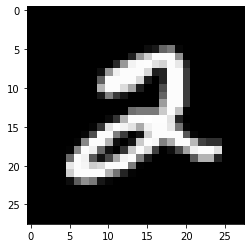

Predigo un [2] cuando en realidad es un 2


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [8]:
pred = 5
(x_train, y_train), (x_test, y_test) = mnist.load_data()
X = numpy.vstack((x_train,x_test))
plt.imshow(X[pred], cmap='gray')
plt.show()                        

X = X / 255.0
X = X.reshape(X.shape[0], -1)
predicted = test.predecir(hof.items[0], X[pred:pred+1])

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y = numpy.vstack((y_train,y_test))
y = y.flatten()

print("Predigo un", predicted,"cuando en realidad es un",y[pred]) 